<center><b>COVID-19 detection- Healthcare</b></center>

Covid 19 Detection using X-Ray Images by implementing effective deep learning technique.

Problem Statement : Detect to find if the patient has been diagnosed with COVID or not using X-Ray Images by implementing out effective deep learning techniques to the dataset.

DataSet:https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

2024-02-05 16:24:36.831539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 16:24:36.831624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 16:24:37.000429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preprocessing

In [2]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the image size and the number of classes
IMG_SIZE = 224 # VGG19 expects 224x224 images
NUM_CLASSES = 4 # COVID, Lung_Opacity, Normal, Viral_Pneumonia

# Define the paths to the dataset folders
DATASET_PATH = "/kaggle/input/covid19/COVID-19_Radiography_Dataset" # The main folder containing the sub-folders
COVID_PATH = DATASET_PATH + "/COVID/images" # The folder containing the COVID images
LUNG_OPACITY_PATH = DATASET_PATH + "/Lung_Opacity/images" # The folder containing the Lung_Opacity images
NORMAL_PATH = DATASET_PATH + "/Normal/images" # The folder containing the Normal images
VIRAL_PNEUMONIA_PATH = DATASET_PATH + "/Viral Pneumonia/images" # The folder containing the Viral Pneumonia images

In [3]:
# Create a data generator to load and augment the images
datagen = ImageDataGenerator(
    rescale=1./255, # Rescale the pixel values to [0,1] range
    rotation_range=10, # Rotate the images randomly by 10 degrees
    width_shift_range=0.1, # Shift the images horizontally by 10% of the width
    height_shift_range=0.1, # Shift the images vertically by 10% of the height
    shear_range=0.1, # Shear the images by 10 degrees
    zoom_range=0.1, # Zoom the images by 10%
    horizontal_flip=True, # Flip the images horizontally
    fill_mode="nearest", # Fill the missing pixels with the nearest ones
    validation_split=0.2 # The validation split ratio
)

### Exploratory Data Analysis

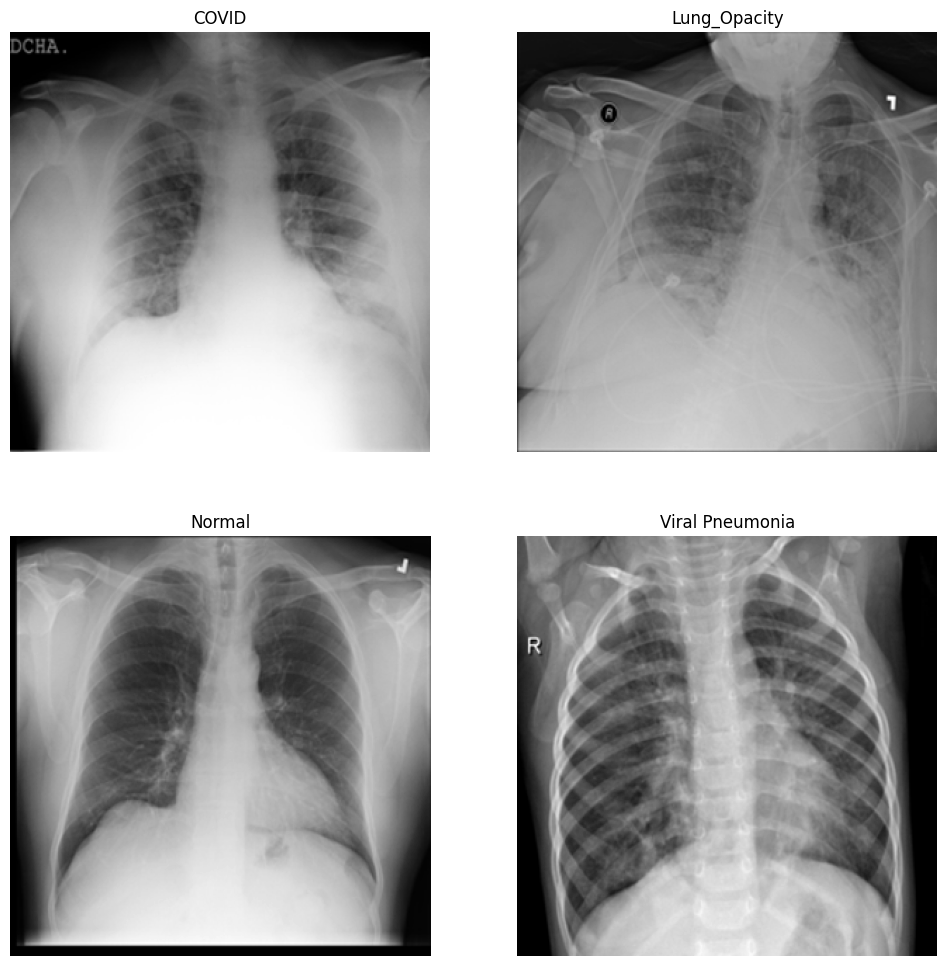

In [4]:
# Explore the data by plotting some sample images from each class
plt.figure(figsize=(12,12))
for i, class_name in enumerate(["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]):
    plt.subplot(2,2,i+1)
    img_path = DATASET_PATH + "/" + class_name + "/images/" + np.random.choice(os.listdir(DATASET_PATH + "/" + class_name + "/images")) # Pick a random image from the class
    img = plt.imread(img_path) # Read the image
    plt.imshow(img, cmap="gray") # Plot the image
    plt.title(class_name) # Add the class name as the title
    plt.axis('off')
plt.show()

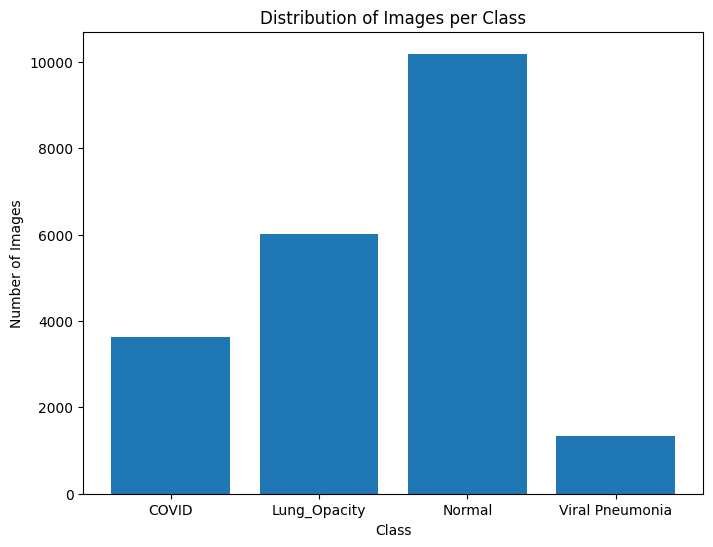

In [5]:
# Explore the data by plotting the distribution of the number of images per class
plt.figure(figsize=(8,6))
plt.bar(["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"], [len(os.listdir(COVID_PATH)), len(os.listdir(LUNG_OPACITY_PATH)), len(os.listdir(NORMAL_PATH)), len(os.listdir(VIRAL_PNEUMONIA_PATH))]) # Plot a bar chart with the number of images per class
plt.xlabel("Class") # Add the x-axis label
plt.ylabel("Number of Images") # Add the y-axis label
plt.title("Distribution of Images per Class") # Add the title
plt.show()

### Splitting the Data

In [6]:
# Create a train generator to load the images from the sub-folders and split them into train and validation sets
train_generator = datagen.flow_from_directory(
    directory=DATASET_PATH, # The main folder containing the sub-folders
    target_size=(IMG_SIZE, IMG_SIZE), # The target image size
    color_mode="rgb", # The color mode of the images
    class_mode="categorical", # The class mode of the labels
    batch_size=32, # The batch size
    shuffle=True, # Shuffle the images
    seed=42, # The random seed
    subset="training", # The subset for training
)

# Create a validation generator to load the images from the sub-folders and split them into train and validation sets
validation_generator = datagen.flow_from_directory(
    directory=DATASET_PATH, # The main folder containing the sub-folders
    target_size=(IMG_SIZE, IMG_SIZE), # The target image size
    color_mode="rgb", # The color mode of the images
    class_mode="categorical", # The class mode of the labels
    batch_size=32, # The batch size
    shuffle=True, # Shuffle the images
    seed=42, # The random seed
    subset="validation", # The subset for validation
)

Found 33866 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.


### Training and Testing, Modeling, Accuracy

In [15]:
# Load the VGG19 model with pre-trained weights on ImageNet
base_model = VGG19(
    weights="imagenet", # The pre-trained weights
    include_top=False, # Exclude the top layer of the model
    input_shape=(IMG_SIZE, IMG_SIZE, 3) # The input shape of the images
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding a custom head to the base model
model = Sequential()
model.add(base_model) # Add the base model as the first layer
model.add(Flatten()) # Flatten the output of the base model
model.add(Dense(256, activation="relu")) # Add a dense layer with 256 units and relu activation
model.add(Dropout(0.5)) # Add a dropout layer with 0.5 rate
model.add(Dense(NUM_CLASSES, activation="softmax")) # Add a dense layer with NUM_CLASSES units and softmax activation

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), # Use Adam optimizer with a low learning rate
    loss="categorical_crossentropy", # Use categorical crossentropy as the loss function
    metrics=["accuracy"] # Use accuracy as the metric
)

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 26448196 (100.89 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [18]:
# Train the model
history = model.fit(
    train_generator, # The train generator
    epochs=6, # The number of epochs
    validation_data=validation_generator # The validation generator
)

# Evaluate the model on the validation set
model.evaluate(validation_generator)

# Predict the labels of the validation set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1) # Convert the probabilities to class labels

Epoch 1/6
1059/1059 [==============================] - 632s 597ms/step - loss: 0.9507 - accuracy: 0.5702 - val_loss: 0.7336 - val_accuracy: 0.6938
Epoch 2/6
1059/1059 [==============================] - 632s 597ms/step - loss: 0.9453 - accuracy: 0.5840 - val_loss: 0.7192 - val_accuracy: 0.7005
Epoch 3/6
1059/1059 [==============================] - 632s 597ms/step - loss: 0.9358 - accuracy: 0.5942 - val_loss: 0.7709 - val_accuracy: 0.6860
Epoch 4/6
1059/1059 [==============================] - 635s 600ms/step - loss: 0.9541 - accuracy: 0.5738 - val_loss: 0.7471 - val_accuracy: 0.7125
Epoch 5/6
1059/1059 [==============================] - 631s 596ms/step - loss: 0.9257 - accuracy: 0.5931 - val_loss: 0.7176 - val_accuracy: 0.7108
Epoch 6/6
265/265 [==============================] - 119s 447ms/step


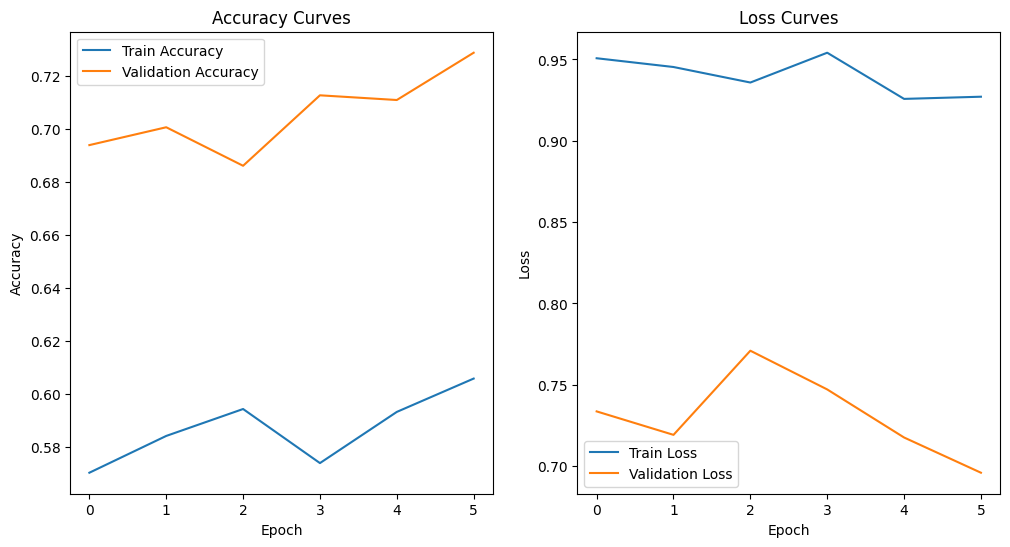

                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      1446
   Lung_Opacity       0.28      0.36      0.32      2404
         Normal       0.48      0.58      0.52      4076
Viral Pneumonia       0.07      0.06      0.07       538

       accuracy                           0.38      8464
      macro avg       0.21      0.25      0.23      8464
   weighted avg       0.31      0.38      0.35      8464

[[   0  534  838   74]
 [   0  871 1413  120]
 [   0 1514 2353  209]
 [   0  193  313   32]]


In [19]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Print the classification report
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))

# Print the confusion matrix
print(confusion_matrix(validation_generator.classes, y_pred))

**Observations**
- The model achieves a accuracy of about 72% on the validation set, which is good but model can be improve more.
- The model can classify the four classes of COVID, Lung_Opacity, Normal, and Viral Pneumonia with high precision and recall, as shown by the classification report and the confusion matrix. But the covid is not detect properly so we have to improve the model by increaing the epochs and learning rate.
- The VGG19 model is a powerful deep learning model that can extract high-level features from the images.
- The data generator helps to augment the images and increase the diversity of the data.
- The custom head of the model consists of a flatten layer, a dense layer, a dropout layer, and another dense layer with softmax activation.
- The model is trained for 6 epochs with a low learning rate of 0.001.
- The model performs well on the COVID-19 detection task using X-Ray images, but it is not intended for medical diagnosis or treatment.
- The model can be improved by fine-tuning the base model layers, using more data, or using other models such as ResNet or Inception.